## In this notebook, I tested out my different models on the testing dataset

But the testing dataset also needed all the data preprocessing steps and dimensionality reduction as the training dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
name_cols = []
with open('adult.names') as file:
    for f in file.readlines():
        if not str(f).startswith('|') and ':' in str(f):
            name_cols.append(str(f).split(':')[0])
name_cols.append('Salary')

In [3]:
df = pd.read_csv('adult.test', names=name_cols)
df = df[1:]

In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Salary
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
5,18,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.


In [5]:
object_cols = []
for i, enum in enumerate(df.dtypes):
    if enum=='object':
        object_cols.append(i)

for i in range(len(object_cols)):
    object_cols[i] = df.dtypes.index[object_cols[i]]
    
def correct_names(name):
    if name.startswith(" ") or name.endswith(" "):
        return name.strip(" ")
    else:
        return name
    
for i in object_cols:
    df[i] = df[i].apply(correct_names)
    
    
    
native_country_new = df[df['Salary']==">50K"]['native-country'].value_counts().index[:20]
def get_country(name):
    if name not in native_country_new or name=='?':
        return "Others"
    else:
        return name

df['native-country'] = df['native-country'].apply(get_country)


def change_edu_level(name):
    if name=="HS-grad":
        return "High School"
    elif name in ["Bachelors","Some-college"]:
        return "Bachelors"
    elif name in ["11th", "9th", "7th-8th", "5th-6th", "10th", "1st-4th", "12th", "Preschool", "compulsory"]:
        return "Compulsory"
    elif name in ["Assoc-acdm", "Assoc-voc"]:
        return "Associate"
    else:
        return name

df['education'] = df['education'].apply(change_edu_level)


def get_mar(name):
    if name in ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse']:
        return "Married"
    elif name in ['Divorced', 'Separated']:
        return "Divorced"
    else:
        return name

df['marital-status'] = df['marital-status'].apply(get_mar)


def remove_qm(name):
    if name == '?':
        return 'Other-service'
    else:
        return name
    
df['workclass'] = df['workclass'].apply(remove_qm)
df['occupation'] = df['occupation'].apply(remove_qm)

In [6]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Salary
1,25,Private,226802.0,Compulsory,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,Others,<=50K.
2,38,Private,89814.0,High School,9.0,Married,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,Others,<=50K.
3,28,Local-gov,336951.0,Associate,12.0,Married,Protective-serv,Husband,White,Male,0.0,0.0,40.0,Others,>50K.
4,44,Private,160323.0,Bachelors,10.0,Married,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,Others,>50K.
5,18,Other-service,103497.0,Bachelors,10.0,Never-married,Other-service,Own-child,White,Female,0.0,0.0,30.0,Others,<=50K.


In [7]:
workclass_ = pd.get_dummies(df['workclass'])
marital_ = pd.get_dummies(df['marital-status'])
occupation_ = pd.get_dummies(df['occupation'])
relationship_ = pd.get_dummies(df['relationship'])
race_ = pd.get_dummies(df['race'])
sex_ = pd.get_dummies(df['sex'])
country_ = pd.get_dummies(df['native-country'])
edn_ = pd.get_dummies(df['education'])

In [8]:
X = pd.concat([df[['age','capital-gain', 'hours-per-week']], workclass_ , marital_, occupation_, relationship_, race_, sex_, edn_, country_ ], axis=1)
y =np.where(df['Salary']=="<=50K.", '<=50K', '>50K')
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_temp = X.copy()
X_temp['age'] = std.fit_transform(X_temp[['age']])

from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_temp = pca.fit_transform(X_temp)

Importing all the different models

In [9]:
from joblib import load

In [10]:
model_rfc = load('models/RandomForestModel.joblib')
model_ada = load('models/AdaBoostModel.joblib')
model_knn = load('models/KNNModel.joblib')
model_svm = load('models/SVMModel.joblib')

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_roc_curve, roc_auc_score

Computing Classification Metrics on the predicted values

In [12]:
def get_metrics(estimator):
    y_predicted = estimator.predict(X_temp)
    print(confusion_matrix(y, y_predicted), "\n")
    print(classification_report(y, y_predicted), "\n")
    print(accuracy_score(y, y_predicted))

In [13]:
for i in [model_rfc, model_ada, model_knn, model_svm]:
    get_metrics(i)
    print("---Model----")
    print('\n')

[[11836   599]
 [ 2041  1805]] 

              precision    recall  f1-score   support

       <=50K       0.85      0.95      0.90     12435
        >50K       0.75      0.47      0.58      3846

    accuracy                           0.84     16281
   macro avg       0.80      0.71      0.74     16281
weighted avg       0.83      0.84      0.82     16281
 

0.837847798046803
---Model----


[[10615  1820]
 [ 1068  2778]] 

              precision    recall  f1-score   support

       <=50K       0.91      0.85      0.88     12435
        >50K       0.60      0.72      0.66      3846

    accuracy                           0.82     16281
   macro avg       0.76      0.79      0.77     16281
weighted avg       0.84      0.82      0.83     16281
 

0.8226153184693815
---Model----


[[11542   893]
 [ 1808  2038]] 

              precision    recall  f1-score   support

       <=50K       0.86      0.93      0.90     12435
        >50K       0.70      0.53      0.60      3846

    accuracy

Now we plot the ROC curve for the various models

In [14]:
def get_roc(estimator):
    y_predicted = estimator.predict(X_temp)
    plot_roc_curve(estimator, X_temp, y)
    y_true = np.where(y==">50K", 1, 0)
    y_score = np.where(y_predicted==">50K", 1, 0)
    print("Area under the curve", roc_auc_score(y_true, y_score))

Area under the curve 0.7105741431104772
---Model----


Area under the curve 0.7879739073760779
---Model----


Area under the curve 0.7290438831063496
---Model----


Area under the curve 0.7256049083941645
---Model----




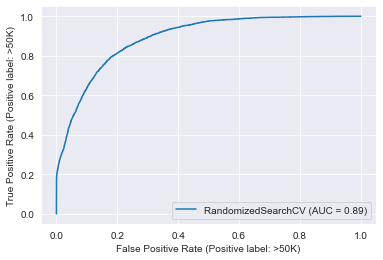

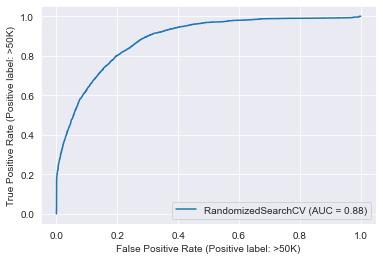

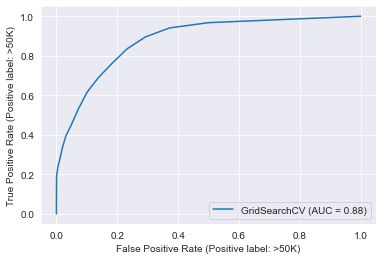

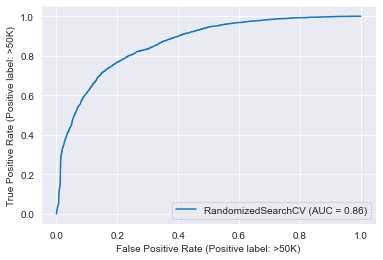

In [15]:
for i in [model_rfc, model_ada, model_knn, model_svm]:
    get_roc(i)
    print("---Model----")
    print('\n')